# SMS Spam Classifier

##Importing necessary libraries

In [ ]:
# Dataframes
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Text Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation
import re

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Resampling
from imblearn.over_sampling import SMOTE

# Importing Model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Metrics evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

###Importing dataset

In [ ]:
df = pd.read_csv("spam_dataset.csv",encoding='latin-1')

##EDA

In [ ]:
df.rename(columns={'v1':'target','v2':'text'},inplace=True)

In [ ]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [ ]:
df.loc[df["target"] == "spam", "target",] = 1
df.loc[df["target"] == "ham", "target",] = 0

In [ ]:
x = df["text"]

y = df["target"]

In [ ]:
type(x)

pandas.core.series.Series

##Preprocessing

#### Abbrevation dataset

In [ ]:
abbreviations = {
    "appt": "appointment",
    "tmrw": "tomorrow",
    "lol": "Laugh out loud",
    "brb": "Be right back",
    "omg": "Oh my God",
    "asap": "As soon as possible",
    "btw": "By the way",
    "idk": "I don't know",
    "ttyl": "Talk to you later",
    "lmk": "Let me know",
    "fyi": "For your information",
    "nvm": "Nevermind",
    "smh": "Shaking my head",
    "imo": "In my opinion",
    "rofl": "Rolling on the floor laughing",
    "afaik": "As far as I know",
    "tmi": "Too much information",
    "tbh": "To be honest",
    "icymi": "In case you missed it",
    "thx": "Thanks",
    "wbu": "What about you?",
    "yolo": "You only live once",
    "y?" : "Why?",
    "jk" : "Just kidding",
    "bc" : "Because",
    "sry": "Sorry",
    "spk" : "Speak",
    "vip": "Very important person or customer",
    "bogo": "Buy one, get one",
    "fomo": "Fear of missing out",
    "2-for-1": "Two items for the price of one",
    "lto": "Limited time offer",
    "cta": "Call to action",
    "roi": "Return on investment",
    "usp": "Unique selling proposition",
    "crm": "Customer relationship management",
    "kpi": "Key performance indicator",
    "faq": "Frequently asked questions",
    "eta": "Estimated time of arrival",
    "rsvp": "please respond",
    "fwd": "Forward",
    "tia" : "Thanks in advance",
    "T&C" : "Terms and conditions",
    "np" : "No problem",
    "eod": "End of day",
    "vfm" : "Value for money",
    "hth": "Hope this helps",
    "otp": "One time password",
    "ff": "Follow Friday",
    "N/A": "Not applicable",
    "k" : "Okay",
    "idc": "I don't care",
}

In [ ]:
def expand_abbreviations(text):
    for word in text.split():
        if word.lower() in abbreviations:
            text = text.replace(word, abbreviations[word.lower()])
    return text

### Text cleaning

In [ ]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Expand abbreviations and acronyms
    text = expand_abbreviations(text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove numeric values (if unwanted for spam detection)
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing Punctuation
    tokens = [word for word in tokens if word not in punctuation]

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    # Normalization
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    return processed_text

# Apply preprocessing and store the result in a new column
df['transformed_text'] = df['text'].apply(preprocess_text)

In [ ]:
df

,target,text,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,nd time tri contact u u pound prize claim easi...
5568,0,Will Ì_ b going to esplanade fr home?,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",piti mood soani suggest
5570,0,The guy did some bitching but I acted like i'd...,guy bitch act like id interest buy someth els ...


## Feature extraction & Resampling

In [ ]:
df['target'] = df['target'].astype(int)

X = df['transformed_text']
y = df['target']

In [ ]:
X

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri wkli comp win fa cup final tkt st m...
3                     u dun say earli hor u c alreadi say
4               nah dont think goe usf live around though
                              ...                        
5567    nd time tri contact u u pound prize claim easi...
5568                                b go esplanad fr home
5569                              piti mood soani suggest
5570    guy bitch act like id interest buy someth els ...
5571                                       rofl true name
Name: transformed_text, Length: 5572, dtype: object

In [ ]:
feature_extraction = TfidfVectorizer(min_df=1, stop_words='english', lowercase=1)

X_features = feature_extraction.fit_transform(X)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [ ]:
print(X_features)

  (0, 6470)	0.19701755757433767
  (0, 201)	0.3546511439487809
  (0, 2333)	0.164572049115277
  (0, 1031)	0.2996107195487308
  (0, 763)	0.3385528517998774
  (0, 3156)	0.2907511900642808
  (0, 6665)	0.24101239908849578
  (0, 2369)	0.19739389473956717
  (0, 765)	0.2996107195487308
  (0, 387)	0.26968351139787927
  (0, 1245)	0.2746528979153773
  (0, 4466)	0.24216329919785426
  (0, 3022)	0.3546511439487809
  (1, 4124)	0.5633086751818669
  (1, 6578)	0.44480400570972006
  (1, 2988)	0.47731294876998304
  (1, 3188)	0.42078899608869724
  (1, 4095)	0.2827396376113674
  (2, 272)	0.1874222074168882
  (2, 4752)	0.2632741014636221
  (2, 6185)	0.13936084366035092
  (2, 4705)	0.2632741014636221
  (2, 4791)	0.18106651040724833
  (2, 5877)	0.13269527435506004
  (2, 5530)	0.17579843527166963
  :	:
  (5567, 6131)	0.27326945854063933
  (5567, 5991)	0.23368413335754223
  (5567, 4516)	0.3466267711673468
  (5567, 1038)	0.2742728652411011
  (5567, 4599)	0.28733562255388156
  (5568, 1806)	0.6932133474261023
  (556

### Resampling

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_features, y)

In [ ]:
print(y_resampled)

0       0
1       0
2       1
3       0
4       0
       ..
9645    1
9646    1
9647    1
9648    1
9649    1
Name: target, Length: 9650, dtype: int64


## Splitting of dataset into Train and test set
SPlitting in 4:1 ratio of training and dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
X_train

<7720x6907 sparse matrix of type '<class 'numpy.float64'>'
	with 88813 stored elements in Compressed Sparse Row format>

In [ ]:
one_s = zero_s = one_h = zero_h = 0

for i in y_resampled:
  if i == 0:
    one_s+=1
  else:
    zero_s+=1


In [ ]:
for i in y_test:
  if i == 0:
    one_h+=1
  else:
    zero_h+=1

In [ ]:
print("train",one_s,zero_s)
print("test",one_h,zero_h)

train 4825 4825
test 985 945


## Model Creation

### Ada Boost Classifier

In [ ]:
adaboost_model = AdaBoostClassifier()

adaboost_model.fit(X_train, y_train)

y_pred_ada = adaboost_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_ada)
conf_matrix = confusion_matrix(y_test, y_pred_ada)
classification_rep = classification_report(y_test, y_pred_ada)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.9709844559585492
Confusion Matrix:
[[964  21]
 [ 35 910]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       985
           1       0.98      0.96      0.97       945

    accuracy                           0.97      1930
   macro avg       0.97      0.97      0.97      1930
weighted avg       0.97      0.97      0.97      1930



### XGBoost model

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=300, learning_rate=1.0, max_depth=300)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
classification_rep = classification_report(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.9844559585492227
Confusion Matrix:
[[972  13]
 [ 17 928]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       985
           1       0.99      0.98      0.98       945

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930



### KNN Model

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
classification_rep = classification_report(y_test, y_pred_knn)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.9979274611398964
Confusion Matrix:
[[981   4]
 [  0 945]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       985
           1       1.00      1.00      1.00       945

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930



### Gradient boosting classifier

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=300, learning_rate=2.0, max_depth=300)

In [ ]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=2.0, max_depth=300, n_estimators=300)

In [ ]:
y_pred_gbc = gbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gbc)
conf_matrix = confusion_matrix(y_test, y_pred_gbc)
classification_rep = classification_report(y_test, y_pred_gbc)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.9772020725388602
Confusion Matrix:
[[962  23]
 [ 21 924]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       985
           1       0.98      0.98      0.98       945

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930



### Randomforest classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=300, max_depth=300, random_state=5)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=300, n_estimators=300, random_state=5)

In [ ]:
y_pred_rf = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
classification_rep = classification_report(y_test, y_pred_rf)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.9927461139896373
Confusion Matrix:
[[985   0]
 [ 14 931]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       985
           1       1.00      0.99      0.99       945

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



### Gaussian Naive bayes

In [ ]:
lr = LogisticRegression(solver='saga',C=3.0,max_iter=100,penalty='l2')

In [ ]:
lr.fit(X_train, y_train)

LogisticRegression(C=3.0, solver='saga')

In [ ]:
y_pred_lr = lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
classification_rep = classification_report(y_test, y_pred_lr)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.9932642487046632
Confusion Matrix:
[[978   7]
 [  6 939]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       985
           1       0.99      0.99      0.99       945

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



In [ ]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [ ]:
gnb = GaussianNB()

In [ ]:
gnb.fit(X_train_dense, y_train)

GaussianNB()

In [ ]:
y_pred_gnb = gnb.predict(X_test_dense)

accuracy = accuracy_score(y_test, y_pred_gnb)
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
classification_rep = classification_report(y_test, y_pred_gnb)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.9217616580310881
Confusion Matrix:
[[834 151]
 [  0 945]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       985
           1       0.86      1.00      0.93       945

    accuracy                           0.92      1930
   macro avg       0.93      0.92      0.92      1930
weighted avg       0.93      0.92      0.92      1930



### Support vector machine classifier

In [ ]:
svc = SVC(kernel='linear', C=2.0, random_state=500,probability=True)

In [ ]:
svc.fit(X_train, y_train)

SVC(C=2.0, kernel='linear', probability=True, random_state=500)

In [ ]:
y_pred_svc = svc.predict(X_test_dense)

accuracy = accuracy_score(y_test, y_pred_svc)
conf_matrix = confusion_matrix(y_test, y_pred_svc)
classification_rep = classification_report(y_test, y_pred_svc)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.9974093264248705
Confusion Matrix:
[[982   3]
 [  2 943]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       985
           1       1.00      1.00      1.00       945

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930



## Evaluation

In [ ]:
predictions = {
    "AdaBoost": y_pred_ada,
    "XGBoost" : y_pred_xgb,
    "KNN" : y_pred_knn,
    "GradientBoost" : y_pred_gbc,
    "RandomForest" : y_pred_rf,
    "LogisiticRegression" : y_pred_lr,
    "SupportVectorClassifier" : y_pred_svc,
    "GaussianNaiveBayes" : y_pred_gnb,
}

In [ ]:
mds = {
    "AdaBoost": adaboost_model,
    "XGBoost" : xgb_model,
    "KNN" : knn,
    "GradientBoost" : gbc,
    "RandomForest" : rf,
    "LogisiticRegression" : lr,
    "SupportVectorClassifier" : svc,
}

In [ ]:
import seaborn as sns
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    cm4= confusion_matrix(y_test,y_pred)
    sns.heatmap(cm4, annot=True,cmap='winter',linewidths=0.3, linecolor='black',annot_kws={"size": 20})
    TP=cm4[0][0]
    TN=cm4[1][1]
    FN=cm4[1][0]
    FP=cm4[0][1]

    accuracy=(TP+TN)/(TP+TN+FN+FP)   # no. of correct predictions
    recall=(TP/(TP+FN))  #how many positive records we predicted correctly(Senesitivity)
    precision=(TP/(TP+FP))
    X=(FP+FN)/2
    f1_score=(TP/(TP+X))  #F1 score is the harmonic mean of recall and percision

    return accuracy,precision,recall,f1_score

For  AdaBoost
Accuracy -  0.9709844559585492
Precision -  0.9786802030456853
Recall -  0.964964964964965
F1 - Score -  0.9717741935483871
For  XGBoost
Accuracy -  0.9844559585492227
Precision -  0.9868020304568528
Recall -  0.9828109201213346
F1 - Score -  0.9848024316109423
For  KNN
Accuracy -  0.9979274611398964
Precision -  0.9959390862944163
Recall -  1.0
F1 - Score -  0.9979654120040692
For  GradientBoost
Accuracy -  0.977720207253886
Precision -  0.9776649746192894
Recall -  0.9786585365853658
F1 - Score -  0.9781615033011681
For  RandomForest
Accuracy -  0.9927461139896373
Precision -  1.0
Recall -  0.985985985985986
F1 - Score -  0.9929435483870968
For  LogisiticRegression
Accuracy -  0.9932642487046632
Precision -  0.9928934010152284
Recall -  0.9939024390243902
F1 - Score -  0.9933976637887253
For  SupportVectorClassifier
Accuracy -  0.9974093264248705
Precision -  0.9969543147208122
Recall -  0.9979674796747967
F1 - Score -  0.9974606399187405
For  SupportVectorClassifier
Ac

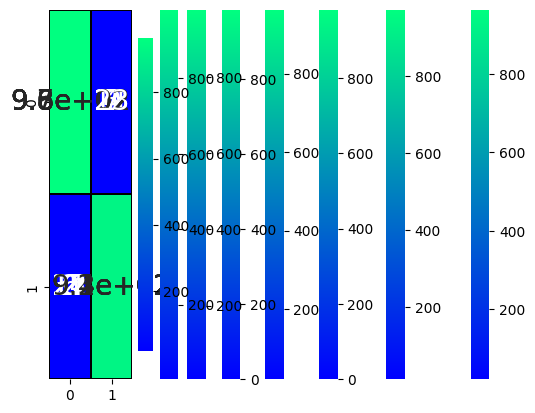

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name,md in mds.items():

    current_accuracy,current_precision,current_recall,current_f1_score = train_classifier(md, X_train,y_train ,X_test, y_test)

    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print("Recall - ",current_recall)
    print("F1 - Score - ",current_f1_score)
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    f1_scores.append(current_f1_score)


current_accuracy,current_precision,current_recall,current_f1_score = train_classifier(gbc, X_train_dense, y_train, X_test_dense, y_test)
print("For ",name)
print("Accuracy - ",current_accuracy)
print("Precision - ",current_precision)
print("Recall - ",current_recall)
print("F1 - Score - ",current_f1_score)
accuracy_scores.append(current_accuracy)
precision_scores.append(current_precision)
recall_scores.append(current_recall)
f1_scores.append(current_f1_score)

In [ ]:
mds["GaussianNaiveBayes"] = gbc

In [ ]:
mmdss = {
    "AdaB": adaboost_model,
    "XGB" : xgb_model,
    "KNN" : knn,
    "GBC" : gbc,
    "RF" : rf,
    "LR" : lr,
    "SVC" : svc,
    "GNB" : gnb,
}

In [ ]:
short_performance_df = pd.DataFrame({'Algorithm':mmdss.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,'Recall':recall_scores,'F1_Score':f1_scores}).sort_values('Accuracy',ascending=False)

In [ ]:
performance_df = pd.DataFrame({'Algorithm':mds.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,'Recall':recall_scores,'F1_Score':f1_scores}).sort_values('Accuracy',ascending=False)

### Accuracy, precision, Recall, F1 Score.

In [ ]:
performance_df

,Algorithm,Accuracy,Precision,Recall,F1_Score
2,KNN,0.997927,0.995939,1.000000,0.997965
6,SupportVectorClassifier,0.997409,0.996954,0.997967,0.997461
5,LogisiticRegression,0.993264,0.992893,0.993902,0.993398
4,RandomForest,0.992746,1.000000,0.985986,0.992944
1,XGBoost,0.984456,0.986802,0.982811,0.984802
3,GradientBoost,0.977720,0.977665,0.978659,0.978162
7,GaussianNaiveBayes,0.976684,0.976650,0.977642,0.977146
0,AdaBoost,0.970984,0.978680,0.964965,0.971774


In [ ]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [ ]:
short_performance_df1 = pd.melt(short_performance_df, id_vars = "Algorithm")

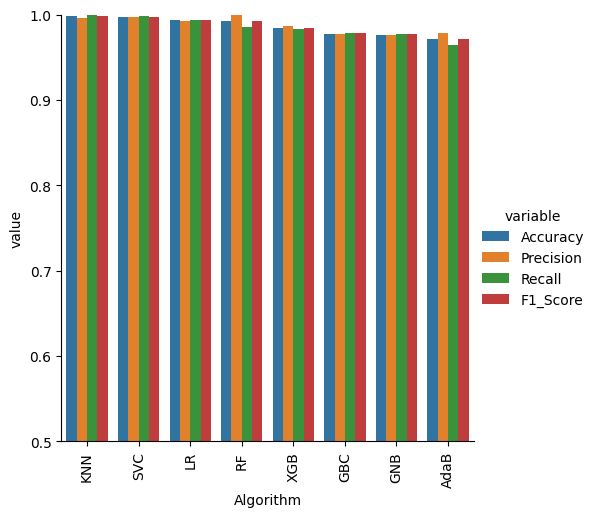

In [ ]:
sns.catplot(x = 'Algorithm', y='value',
               hue = 'variable',data=short_performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

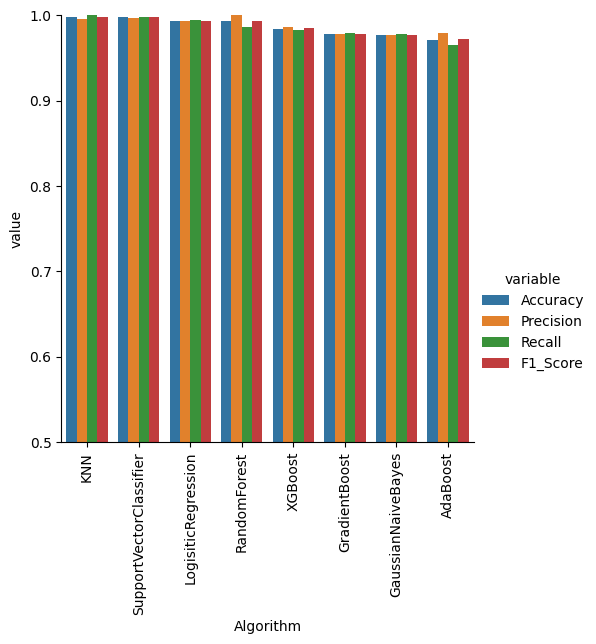

In [ ]:
sns.catplot(x = 'Algorithm', y='value',
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

### Confusion matrix aka Heatmap

[Text(0.5, 23.52222222222222, 'KNN')]

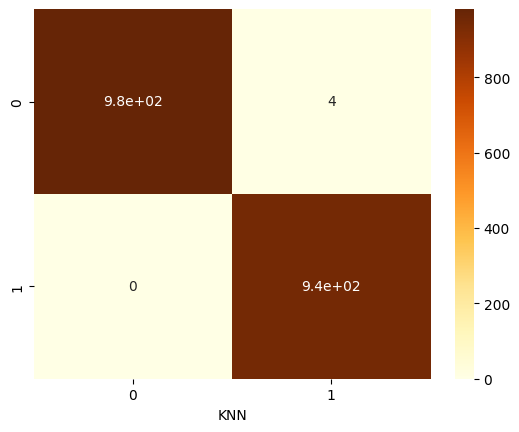

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred_knn)
s=sns.heatmap(cf_matrix, annot=True,cmap="YlOrBr")
s.set(xlabel="KNN")

[Text(0.5, 23.52222222222222, 'AdaBoost')]

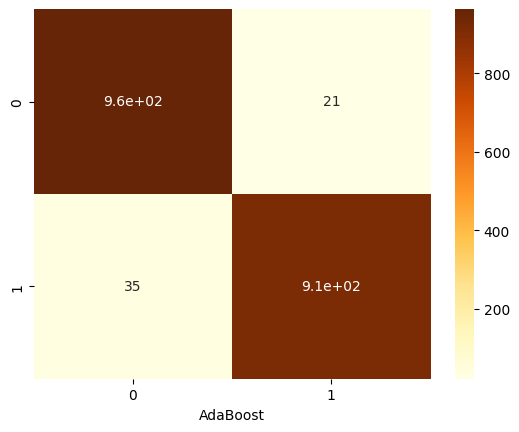

In [ ]:
s=sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot=True,cmap="YlOrBr")
s.set(xlabel="AdaBoost")

[Text(0.5, 23.52222222222222, 'Logistic Regression')]

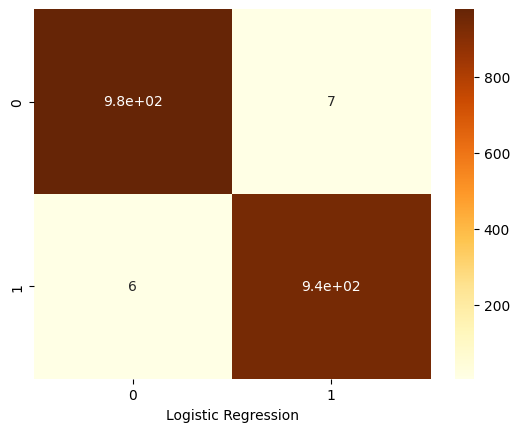

In [ ]:
s=sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True,cmap="YlOrBr")
s.set(xlabel="Logistic Regression")

[Text(0.5, 23.52222222222222, 'Random Forest')]

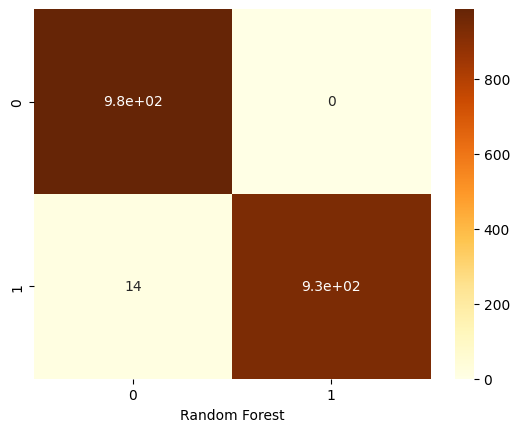

In [ ]:
s=sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True,cmap="YlOrBr")
s.set(xlabel="Random Forest")

[Text(0.5, 23.52222222222222, 'Gaussian Naive Bayes')]

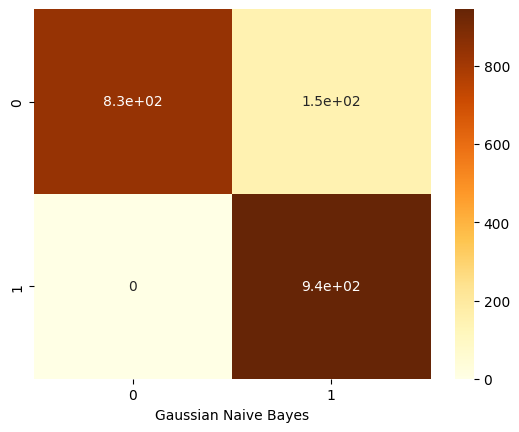

In [ ]:
s=sns.heatmap(confusion_matrix(y_test, y_pred_gnb), annot=True,cmap="YlOrBr")
s.set(xlabel="Gaussian Naive Bayes")

[Text(0.5, 23.52222222222222, 'Gradient Boost')]

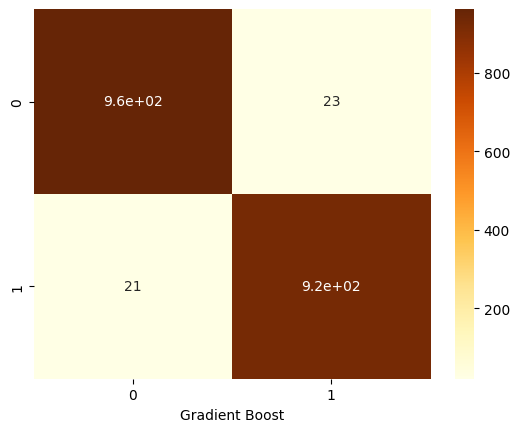

In [ ]:
s=sns.heatmap(confusion_matrix(y_test, y_pred_gbc), annot=True,cmap="YlOrBr")
s.set(xlabel="Gradient Boost")

[Text(0.5, 23.52222222222222, 'XGBoost')]

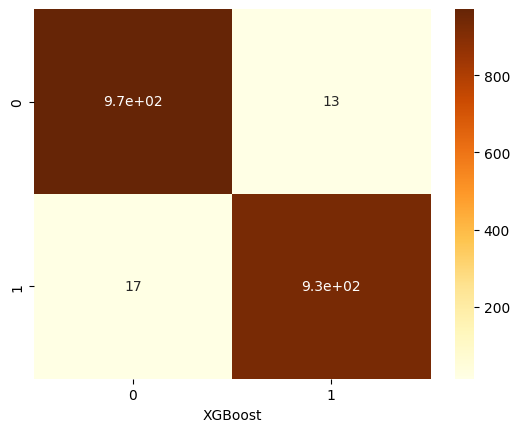

In [ ]:
s=sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True,cmap="YlOrBr")
s.set(xlabel="XGBoost")

[Text(0.5, 23.52222222222222, 'Support Vector Classifier')]

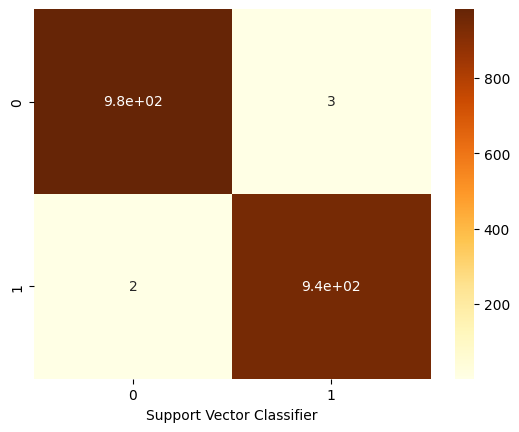

In [ ]:
s=sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot=True,cmap="YlOrBr")
s.set(xlabel="Support Vector Classifier")

### ROC Curve

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

def plot_roc_curve(clf, true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

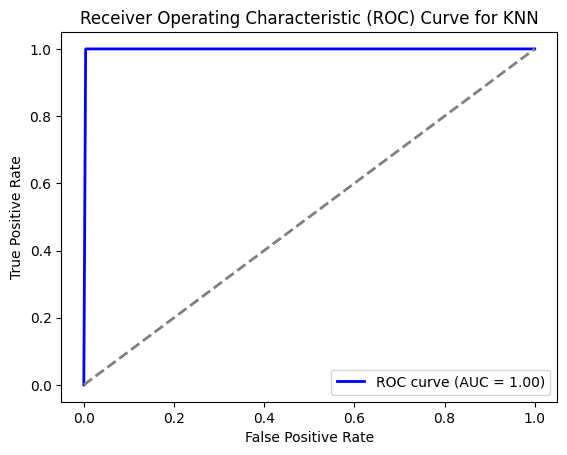

In [ ]:
y_prob = knn.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc='lower right')
plt.show()

In [ ]:
predictions

{'AdaBoost': array([0, 0, 0, ..., 1, 1, 0]),
 'XGBoost': array([0, 0, 0, ..., 1, 1, 0]),
 'KNN': array([0, 0, 0, ..., 1, 1, 0]),
 'GradientBoost': array([0, 0, 0, ..., 1, 1, 0]),
 'RandomForest': array([0, 0, 0, ..., 1, 1, 0]),
 'LogisiticRegression': array([0, 0, 0, ..., 1, 1, 0]),
 'SupportVectorClassifier': array([0, 0, 0, ..., 1, 1, 0]),
 'GaussianNaiveBayes': array([0, 0, 0, ..., 1, 1, 0])}

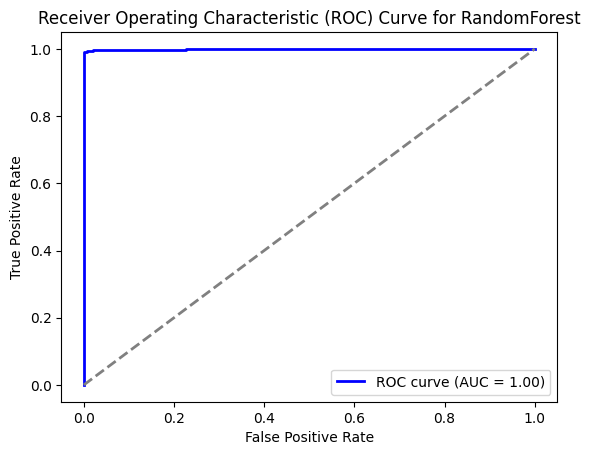

In [ ]:
y_prob = rf.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for RandomForest')
plt.legend(loc='lower right')
plt.show()

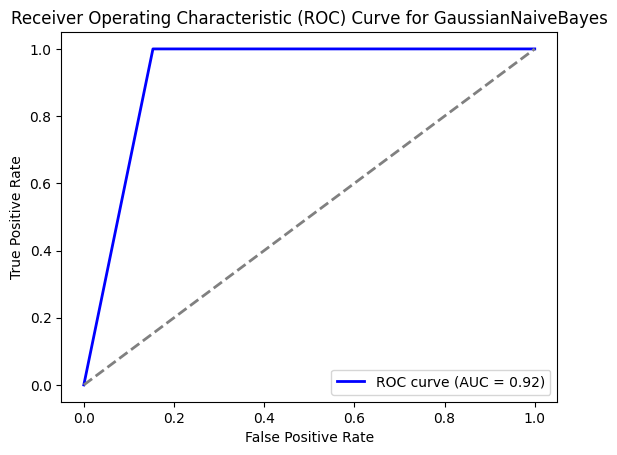

In [ ]:
y_prob = gnb.predict_proba(X_test_dense)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for GaussianNaiveBayes')
plt.legend(loc='lower right')
plt.show()

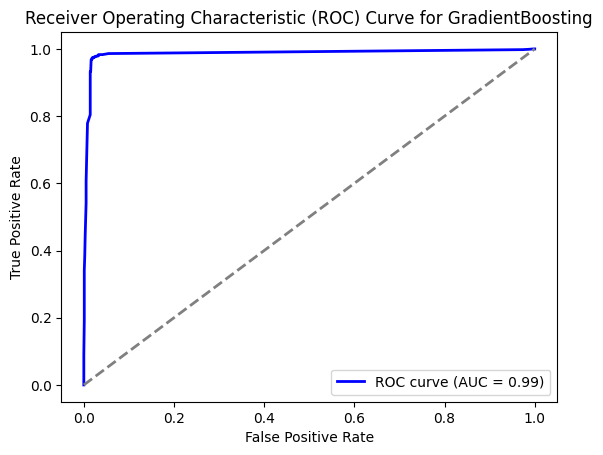

In [ ]:
y_prob = gbc.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for GradientBoosting')
plt.legend(loc='lower right')
plt.show()

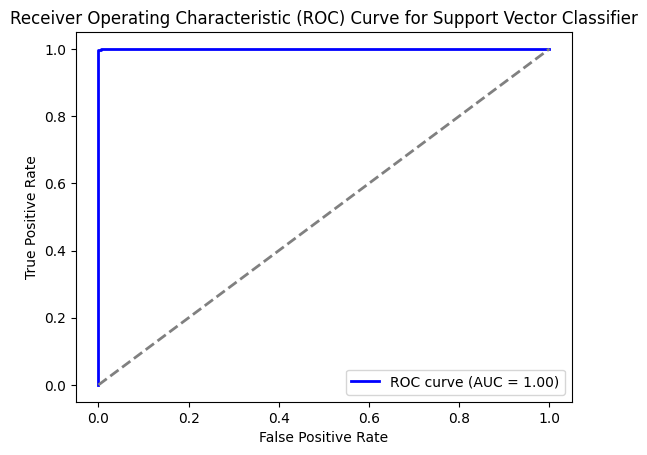

In [ ]:
y_prob = svc.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for Support Vector Classifier')
plt.legend(loc='lower right')
plt.show()

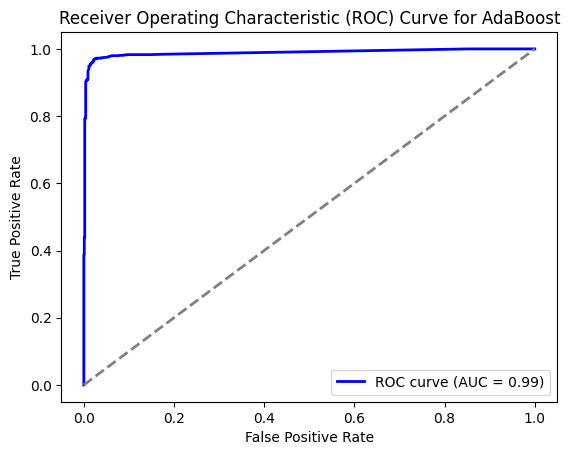

In [ ]:
y_prob = adaboost_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for AdaBoost')
plt.legend(loc='lower right')
plt.show()

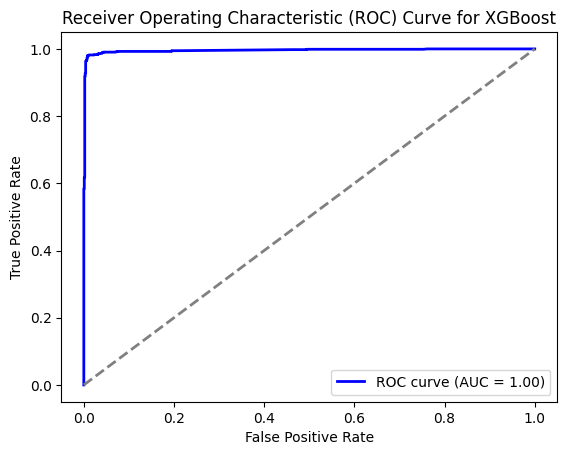

In [ ]:
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

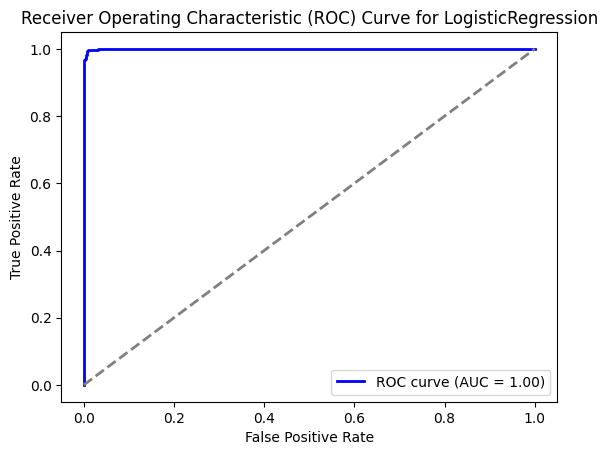

In [ ]:
y_prob = lr.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for LogisticRegression')
plt.legend(loc='lower right')
plt.show()